##### Set maximum number of threads for parallelizing 

In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

##### Import packages and util functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_LR
from SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, get_train_test_split
from SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score, precision_recall_fscore_support
from sklearn.inspection import permutation_importance
# from sklearn.pipeline import Pipeline
from SHIPS_plotting import plot_roc_curve, plot_precision_recall_vs_threshold,add_model_results,make_performance_diagram_background
from SHIPS_plotting import plot_CSI_vs_bias, plot_basic_score_basin, plot_PD_curves
import matplotlib.colors
# imblearn
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler,NearMiss
from SHIPS_ML_model_funcs_imblearn import create_gridsearch_LR_sampler

##### Ignore Annoying Warnings

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore",category=ConvergenceWarning)

### Model Parameters

##### SHIPS Dataset Choice
* max_fore: maximum forecast hours [usually 24 or 48]
* mask_TYPE: how are we handling cases close to land? [SIMPLE_MASK or no_MASK]
* interp_str: Did we interpolate over missing data or not? [INTERP: yes, no_INTERP: no]
* pred_set:  Set of predictors we used.  Default is 'BASIC' but if we want to change the predictors we are using we can do that.
* yr_start:  First year of training data [2010 or 2005, generally]
* yr_end:  Last year of training data [2020; data actually ends on 12/31/2019]
* use_basin:  Default is to use all basins, but if we just want to use one basin, we can specify that here [ATLANTIC, EAST_PACIFIC, WEST_PACIFIC, and SOUTH_PACIFIC are the choices]

In [4]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end = 2019
use_basin = 'ALL'

#### SHIPS analysis choices

In [5]:
hrs_max = 24
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True

#### ML Model Hyperparameters.  This will change based on the type of model
* <code>Solver</code>:  For logistic regression models, we have a few choices of solver. We will stick only with solvers that can handle multi-class classification, as we want to be able to compare different formulations of this problem. We have a few options:
 * The default solver, <code>'lbfgs'</code>, (stands for Limited-memory Broyden-Fletcher-Goldfarb-Shanno).  Approximates second derivative with gradient evaluations; only stores last few updates, so saves memory.  Not super fast.
 * <code>sag</code>: stands for "stochastic average gradient".  A version of gradient descent.  Fast for big datasets. 
 * <code>saga</code>: a version of <code>sag</code> that allows for <code>L1</code> regularizaiton. 
* <code> Penalty</code>: Are we regularizing using the L1 norm (absolute-value based) or the L2 norm (least-squares based)? For <code>sag</code> and <code>lbfgs</code>, we will use the <code>L2</code> penalty; for <code>saga</code> we will use <code>L1</code>. 
* <code>k_folds</code>: number of folds used in our cross-validation approach.  We will use a <code>Stratified K-Means cross-validation</code> since we have imbalanced classes. 

##### Class weighting
This part is tricky but important.  Since we are really interested in rapid intensification, which is by definition, rare, we will inherently be creating imbalanced classes for our data.  We can address this in many ways.  Broadly, we can either use <b>class weights</b> (which apply different weights to each data point based on which class it is in), or we can use under/over sampling.  <b>Undersampling</b> means we will sample the minority class at a rate that is commeasurate with the majority class--we lose information, but are less likely to overfit to our minority class.  <b>Oversampling</b> means we will draw additional samples from our minority class to match the size of our majority class.  

We'll try a few different ways of applying class weights, and we'll try undersampling.  Since our minority classes can be quite small, we will avoid oversampling (for now, at least).

In [7]:
solver = 'saga'
k_folds = 10
n_repeats = 3
# Use L1 penalty for SAGA, use L2 for others.
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'
# Weights

to_predict = 'I_class'
# Model hyperparameters
C_vals = np.logspace(-2,2,5) 
max_iter = np.logspace(2,4,3)

##### Load our pre-processed SHIPS files

In [8]:
SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin)

##### Create file output names

##### Set up bootstrapping

In [9]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()

In [10]:
N_samples = 15
ncats = 2
scoring = 'f1_weighted'
cut = 'equal'
# Create our sampler
sampler = NearMiss(version=1)
sampler_str = 'under'
sample_save_str = 'nearmiss_1'
FULL_yrs = np.arange(yr_start,yr_end,1)
n_valid = 3 # number of years to leave out for validation

In [11]:
for i in np.arange(0,N_samples):
#i = 0
    print('running sample ',i)
    test_years = np.random.choice(FULL_yrs,n_valid,replace=False)
    X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                    is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
    #
    LR_model = create_gridsearch_LR_sampler(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,scoring,
                                        sampler,sampler_str)

    print('fitting model')
    LR_model.fit(X_train,y_train['I_class'])

    # 
    BASIN_all = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTH_PACIFIC','ALL']
    print('calculating scores')

    for basin in BASIN_all:
        #basin = 'ATLANTIC'
        print('running ',basin)
        report, y_true, y_pred = get_scores_best_params_LR(LR_model,X_test,y_test,basin)
        report['Years Out'] = str(test_years)
        report['Model'] = solver
        report['Fold'] = i
        label_names = ['not RI','RI']

        #
        cm_stats = get_confusion_matrix_LR(LR_model,y_true,y_pred,basin,label_names,ncats)
        cm_stats['Years Out'] = str(test_years)
        cm_stats['Model'] = solver
        cm_stats['Fold'] = i
        #
        fi_pred = get_feature_importances_LR(LR_model,X_test,y_test,basin,scoring)
        fi_pred['Years Out'] = str(test_years)
        fi_pred['Fold'] = i
        fi_pred['Model'] = solver
        #
        fi_pred_train = get_feature_importances_LR(LR_model,X_train,y_train,basin,scoring)
        fi_pred_train['Years Out'] = str(test_years)
        fi_pred_train['Fold'] = i
        fi_pred_train['Model'] = solver
        #
        ypred_prob, p_vs_r, roc_vals = get_roc_auc(X_test,basin,LR_model,y_test,1,'RI',scoring,cut)

        #
        p_vs_r['Fold'] = i
        p_vs_r['Years Out'] = str(test_years)
        p_vs_r['Model'] = solver
        roc_vals['Fold'] = i
        roc_vals['Model'] = solver
        roc_vals['Years Out'] = str(test_years)
        #
        if basin != 'ALL':
            y_pred_all = y_test.xs(basin).copy()
        else:
            y_pred_all = y_test.copy()
        y_pred_all['Y pred'] = y_pred
        y_pred_all['Predicted Basin'] = basin
        y_pred_all['Model'] = solver
        y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
        y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
        #
        predicted_y_ALL = predicted_y_ALL.append(y_pred_all.reset_index())
        roc_vals_ALL = roc_vals_ALL.append(roc_vals)
        p_vs_r_ALL = p_vs_r_ALL.append(p_vs_r)
        fi_pred_ALL = fi_pred_ALL.append(fi_pred)
        fi_pred_train_ALL = fi_pred_train_ALL.append(fi_pred_train)
        cm_ALL = cm_ALL.append(cm_stats)
        report_ALL = report_ALL.append(report)

running sample  0
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTH_PACIFIC
running  ALL
running sample  1
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  2
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTH_PACIFIC
running  ALL
running sample  3
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  4
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC
running  ALL
running sample  5
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  6
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  7
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  8
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC
running  SOUTH_PACIFIC
running  ALL
running sample  9
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  10
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  11
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC
running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  12
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL
running sample  13
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC
running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  14
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTH_PACIFIC


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_ML_model_funcs.py:368: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


In [12]:
predicted_y_ALL = predicted_y_ALL.drop(columns={'BASIN'})
predicted_y_ALL['BASIN'] = predicted_y_ALL['Predicted Basin']


<AxesSubplot:xlabel='BASIN', ylabel='1.0'>

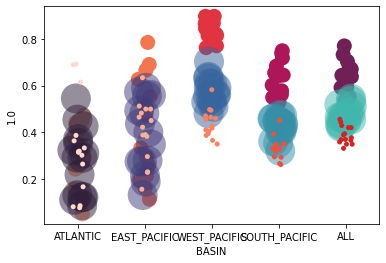

In [13]:
foo = report_ALL.reset_index().rename(columns={'index':'Score'})
foo2 = foo.set_index(['Score'])
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='1.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='1.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='1.0',palette=sns.color_palette('Reds'),s=5)


In [14]:
foo2#.xs('Recall').groupby(['BASIN']).max()

0.0         1.0  accuracy    macro avg  weighted avg  \
Score                                                                     
precision     0.908571    0.314286  0.809524     0.611429      0.832163   
recall        0.868852    0.407407  0.809524     0.638130      0.809524   
f1-score      0.888268    0.354839  0.809524     0.621553      0.819684   
support     183.000000   27.000000  0.809524   210.000000    210.000000   
precision     0.788945    0.228571  0.705128     0.508758      0.669207   
...                ...         ...       ...          ...           ...   
support     378.000000   98.000000  0.663866   476.000000    476.000000   
precision     0.854000    0.389011  0.708591     0.621505      0.750776   
recall        0.754417    0.547988  0.708591     0.651202      0.708591   
f1-score      0.801126    0.455013  0.708591     0.628069      0.724291   
support    1132.000000  323.000000  0.708591  1455.000000   1455.000000   

                   BASIN     C  Max Iter         Years Out Model  Fold  
Score                                                                   
precision       ATLANTIC   0.1    1000.0  [2011 2007 2016]  saga     0  
recall          ATLANTIC   0.1    1000.0  [2011 2007 2016]  saga     0  
f1-score        ATLANTIC   0.1    1000.0  [2011 2007 2016]  saga     0  
support         ATLANTIC   0.1    1000.0  [2011 2007 2016]  saga     0  
precision   EAST_PACIFIC   0.1    1000.0  [2011 2007 2016]  saga     0  
...                  ...   ...       ...               ...   ...   ...  
support    SOUTH_PACIFIC  10.0    1000.0  [2012 2010 2018]  saga    14  
precision            ALL  10.0    1000.0  [2012 2010 2018]  saga    14  
recall               ALL  10.0    1000.0  [2012 2010 2018]  saga    14  
f1-score             ALL  10.0    1000.0  [2012 2010 2018]  saga    14  
support              ALL  10.0    1000.0  [2012 2010 2018]  saga    14  

[300 rows x 11 columns]

<AxesSubplot:xlabel='BASIN', ylabel='0.0'>

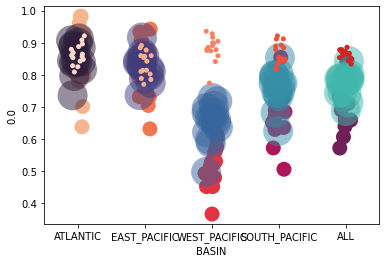

In [15]:
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='0.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='0.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='0.0',palette=sns.color_palette('Reds'),s=5)


In [16]:
save_dir = 'Model_Results/COMPARE_SAMPLING/'
model_type = 'LOGISTIC'
save_dir = save_dir+model_type+'/Figures/'
save_extension = '_{solver}_{sample_str}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.csv'.format(solver=solver,sample_str = sample_save_str,yr_start=yr_start,
                                           yr_end=yr_end,mask_TYPE=mask_TYPE,stand_str=stand_str,
                                           RI_thresh=RI_thresh,N=N_samples,scoring=scoring)
save_ext_figs = '_{solver}_{sample_str}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.png'.format(solver=solver,sample_str=sample_save_str,yr_start=yr_start,
                                    yr_end=yr_end,mask_TYPE=mask_TYPE,stand_str=stand_str,
                                    RI_thresh=RI_thresh,N=N_samples,scoring=scoring)

In [17]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
fi_pred_ALL.to_csv(save_dir+'Feat_Imp'+save_extension)
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)

SHIPS/SHIPS_clean/Model_Results/COMPARE_SAMPLING/LOGISTIC

#### Finally, get the best model, fit over all data, and validate with 2020

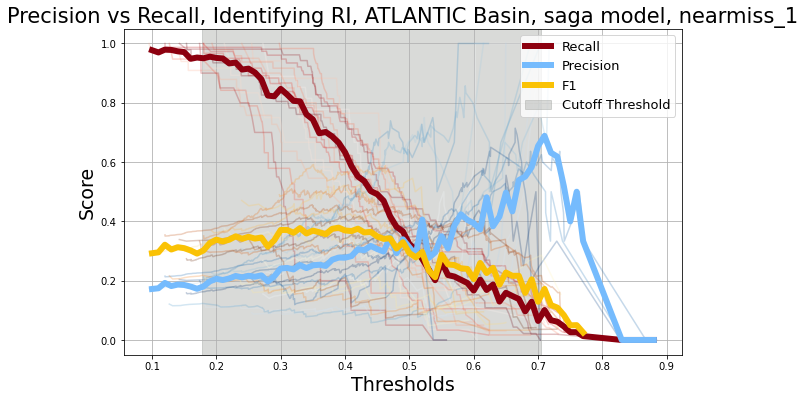

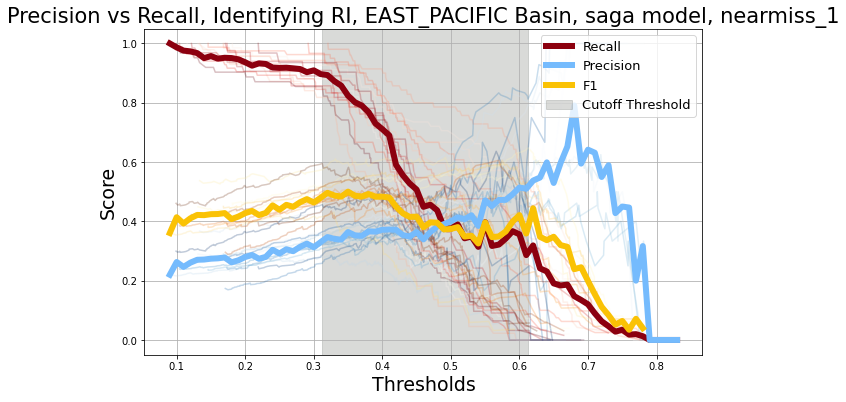

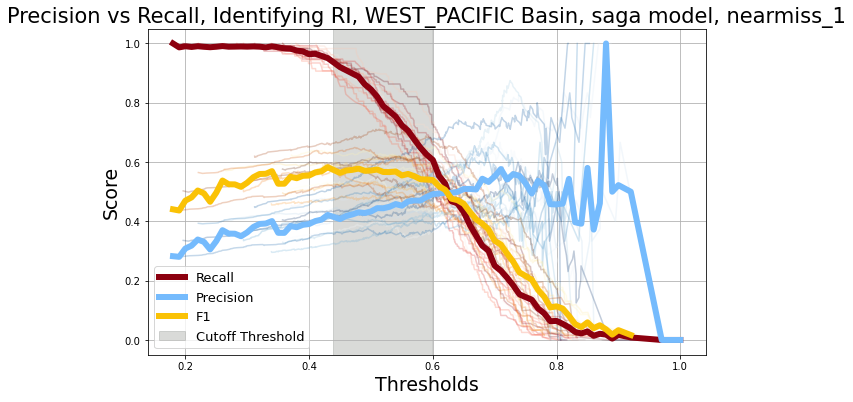

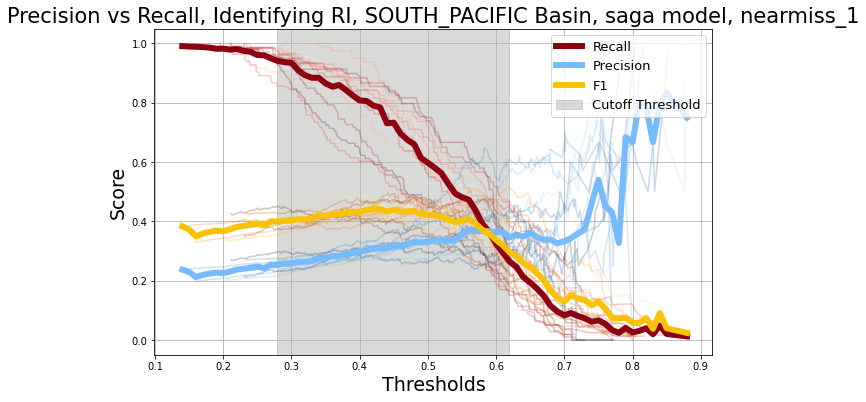

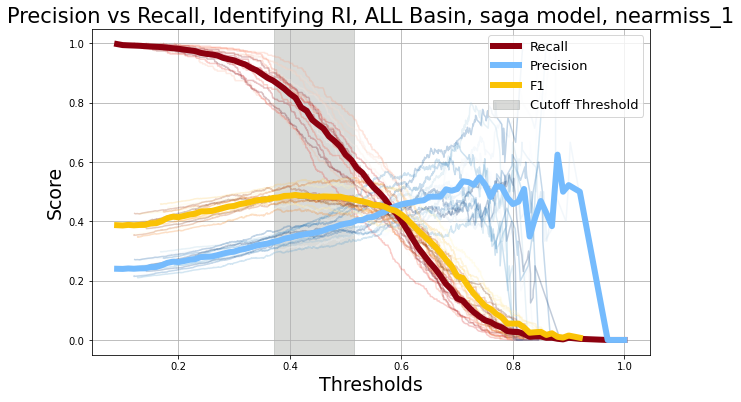

In [18]:
p_vs_r_ALL_plt = p_vs_r_ALL.reset_index()#.iloc[::2]
#basin_sel = 'ALL'

for basin_sel in BASIN_all:
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Recall',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'Reds')
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Precision',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'Blues')
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='F1',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'YlOrBr')
    thresh_min = foo2.reset_index()['Cutoff Threshold'].min()
    thresh_max = foo2.reset_index()['Cutoff Threshold'].max()

    ax1.axvspan(thresh_min,thresh_max,alpha=0.35,color='xkcd:gray',label='Cutoff Threshold')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Recall',ax=ax1,linewidth=6,color='xkcd:crimson',label='Recall')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Precision',ax=ax1,linewidth=6,color='xkcd:sky blue',label='Precision')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='F1',ax=ax1,linewidth=6,color='xkcd:goldenrod',label='F1')
    ax1.set_xlabel('Thresholds',fontsize=19)
    ax1.set_ylabel('Score',fontsize=19)
    ax1.legend(fontsize=13)
    ax1.grid()
    ax1.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basin, '\
                  '{solver} model, {sample_str}'.format(basin_sel=basin_sel,solver=solver,
                                                    sample_str=sample_save_str),fontsize=21)
    fig1.savefig(save_dir+'P_vs_R_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,format='png',
                 dpi=250,bbox_inches='tight')

In [19]:
mf = p_vs_r['F1'].max()
imf = p_vs_r.where(p_vs_r['F1']==mf).dropna(how='all').index
imf.values

array([669])

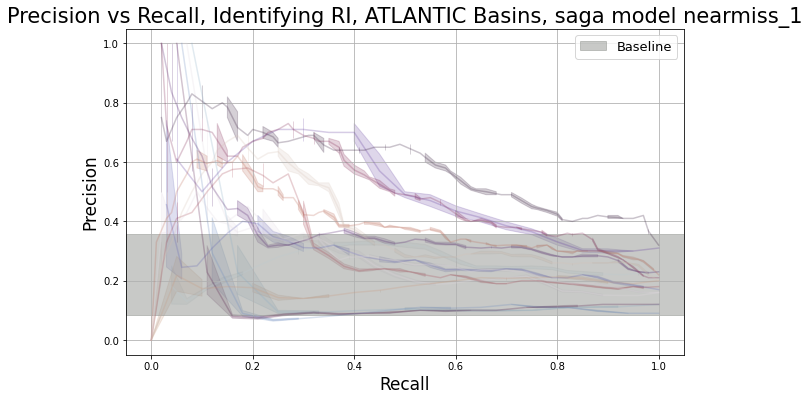

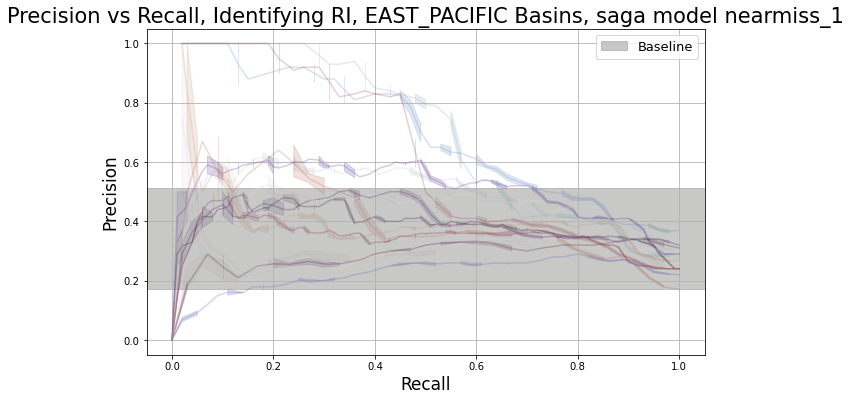

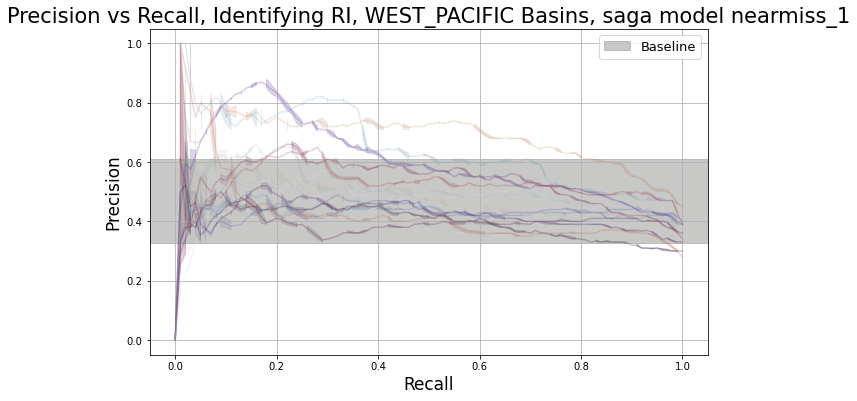

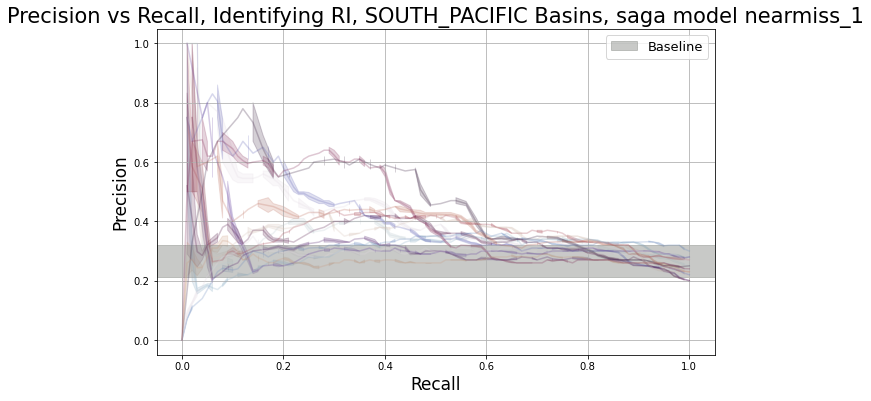

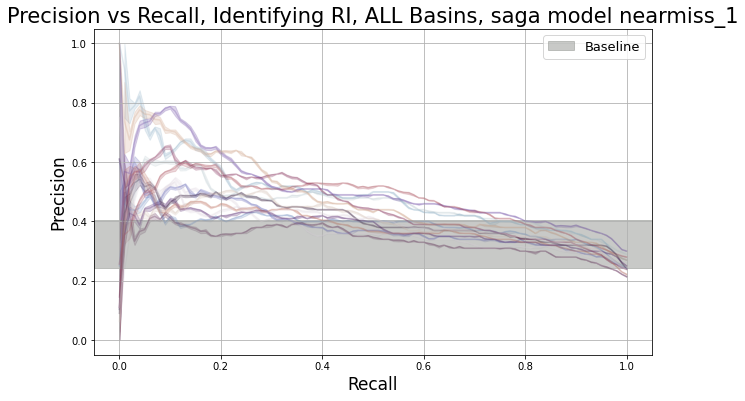

In [20]:
#asin_sel = 'ALL'
for basin_sel in BASIN_all:
    boo = cm_ALL.groupby(['BASIN','Category Names','Fold']).mean()
    y_baseline = boo.xs('RI',level=1)['N_actual']/boo.xs('not RI',level=1)['N_actual']
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig10,ax10 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index().round(2),x='Recall',y='Precision',hue='Fold',ax=ax10,alpha=0.25,legend=None,
                palette='twilight')
    ax10.axhspan(y_baseline.loc[basin_sel].min(),y_baseline.loc[basin_sel].max(),
                color='xkcd:gray',alpha=0.5,label='Baseline')
    ax10.set_xlabel('Recall',fontsize=17)
    ax10.set_ylabel('Precision',fontsize=17)
    ax10.legend(fontsize=13)
    ax10.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basins, {solver} model '\
                   '{sample_str}'.format(basin_sel=basin_sel,solver=solver,sample_str=sample_save_str),fontsize=21)
    ax10.grid()
    fig10.savefig(save_dir+'P_vs_R_no_thresh_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,format='png',
                     dpi=250,bbox_inches='tight')

In [21]:
y_baseline.loc[basin_sel]


Fold
0     0.258278
1     0.361678
2     0.348611
3     0.297968
4     0.278781
5     0.403206
6     0.286311
7     0.285455
8     0.241587
9     0.288250
10    0.335632
11    0.254678
12    0.335837
13    0.281395
14    0.285336
Name: N_actual, dtype: float64

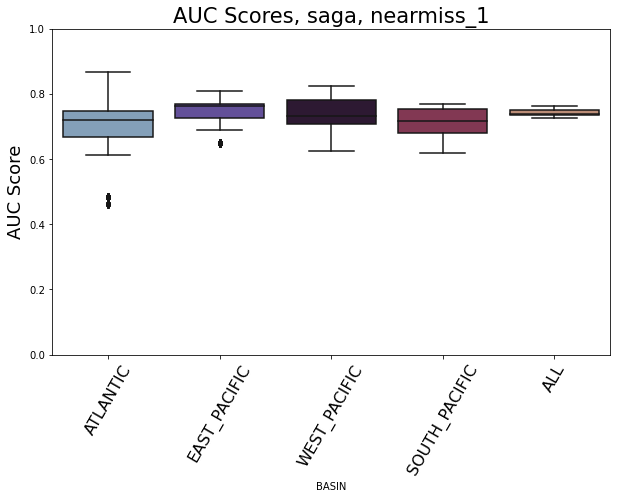

In [26]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=roc_vals_ALL,x='BASIN',y='AUC ROC Score',ax=ax3,palette='twilight')
ax3.set_ylim([0,1])
ax3.set_xticklabels(roc_vals_ALL['BASIN'].unique(),fontsize=16,rotation=60)
ax3.set_ylabel('AUC Score',fontsize=18)
ax3.set_title('AUC Scores, {solver}, {sample_str}'.format(solver=solver,sample_str=sample_save_str),fontsize=21)
fig3.savefig(save_dir+'AUC_scores_all_basins_{solver}'.format(solver=solver)+save_ext_figs,
           format='png',dpi=250,bbox_inches='tight')

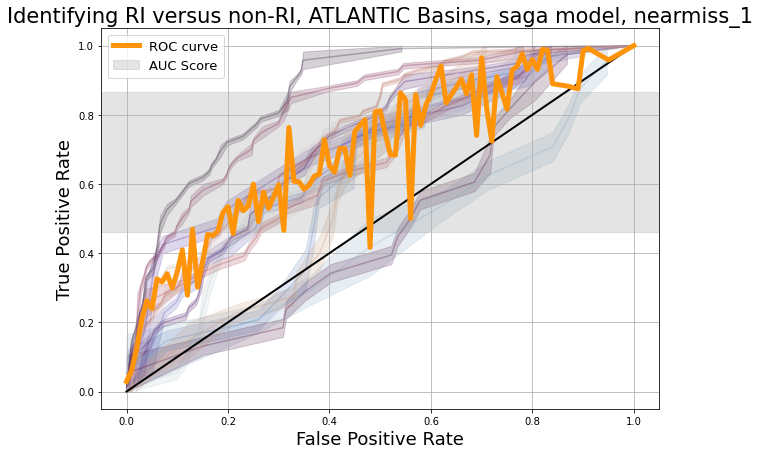

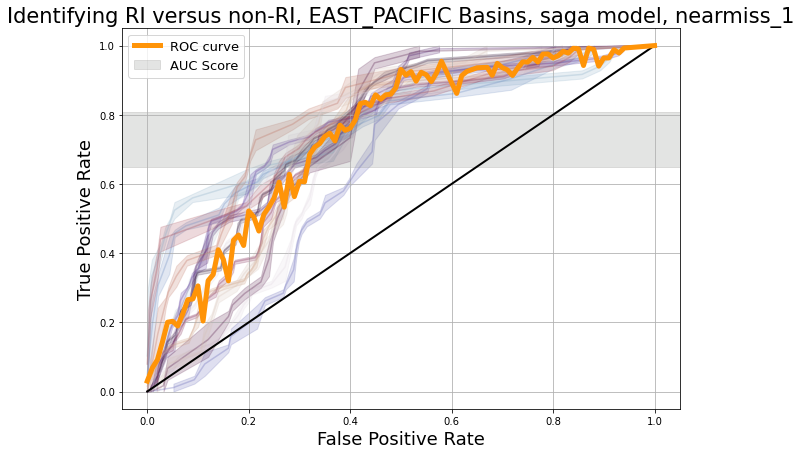

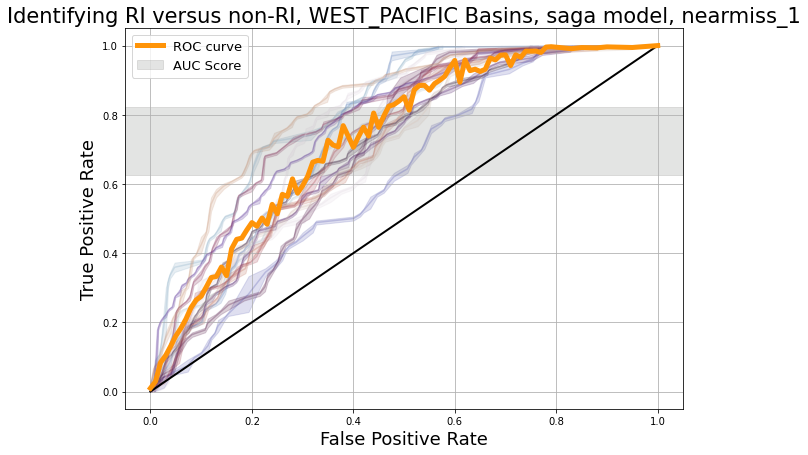

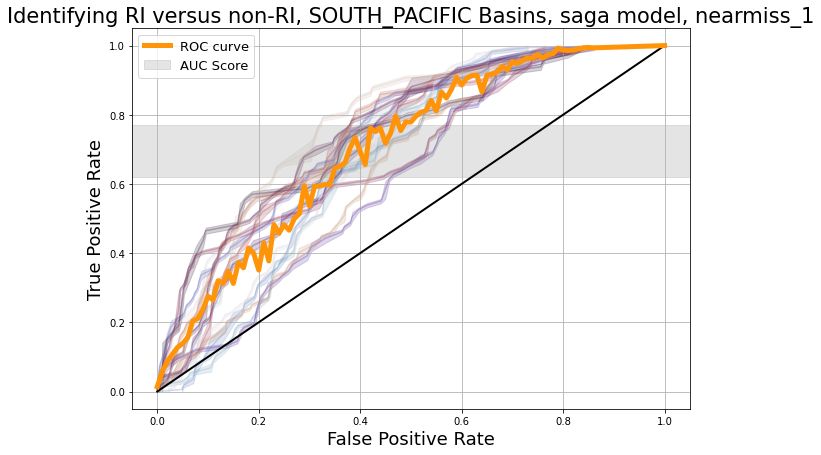

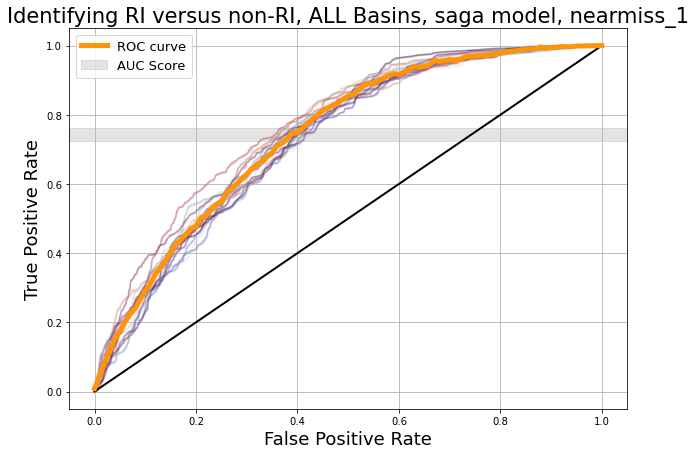

In [27]:
for basin_sel in BASIN_all:
    fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
    roc_vals_plt = roc_vals_ALL.set_index(['BASIN']).xs(basin_sel).reset_index()
    roc_min = roc_vals_plt['AUC ROC Score'].min()
    roc_max = roc_vals_plt['AUC ROC Score'].max()

    sns.lineplot(data=roc_vals_plt,x='False Positive Rate',y='True Positive Rate',hue='Fold',ax=ax2,legend=False,
                alpha=0.3,palette='twilight')
    ax2.plot([0,1],[0,1],color='k',linewidth=2)
    ax2.axhspan(roc_min,roc_max,color='xkcd:gray',alpha=0.25,label='AUC Score')
    ax2.set_xlabel('False Positive Rate',fontsize=18)
    ax2.set_ylabel('True Positive Rate',fontsize=18)
    roc_vals_mean = roc_vals_plt.groupby(roc_vals_plt['False Positive Rate'].round(2))[['True Positive Rate',
                                    'AUC Thresholds']].mean().reset_index()
    roc_vals_mean.plot(x='False Positive Rate',y='True Positive Rate',ax=ax2,color='xkcd:tangerine',linewidth=5,
                      label='ROC curve')
    ax2.legend(fontsize=13)
    ax2.grid()
    ax2.set_title('Identifying RI versus non-RI, {basin_sel} Basins, '\
                  '{solver} model, {sample_str}'.format(basin_sel=basin_sel,solver=solver,
                                                        sample_str=sample_save_str),fontsize=21)
    f2_save = save_dir+'ROC_curve_{basin_sel}'.format(basin_sel=basin_sel)
    fig2.savefig(f2_save+save_ext_figs,format='png',
                 dpi=250,bbox_inches='tight')

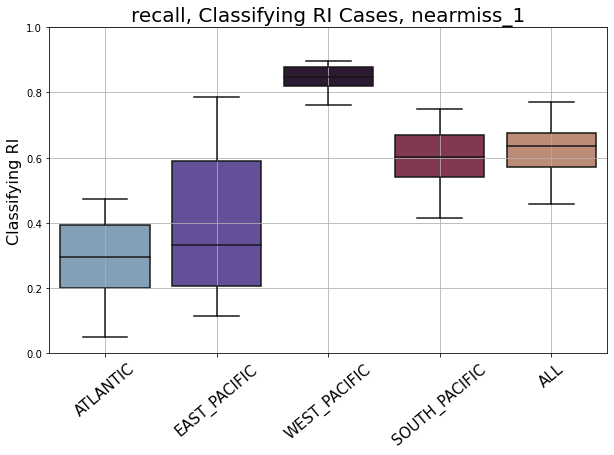

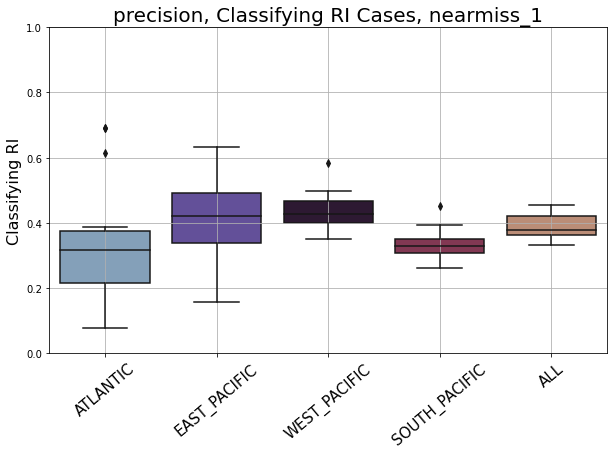

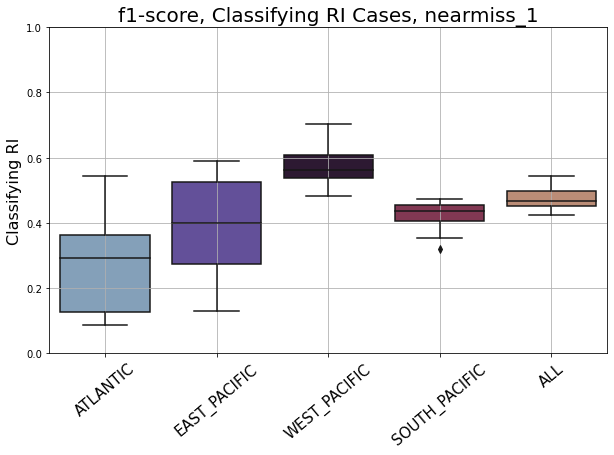

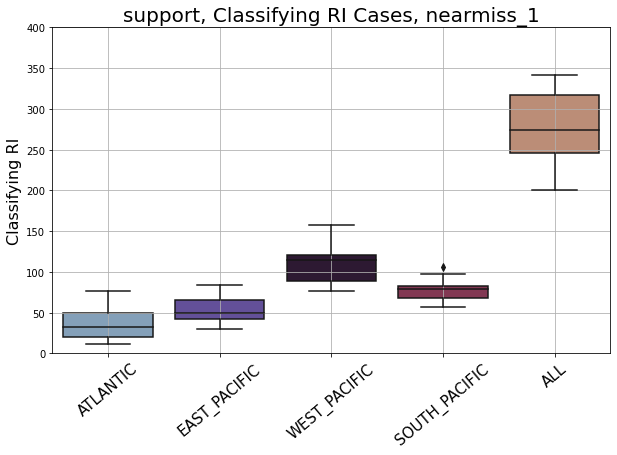

In [28]:
report_plot = report_ALL.reset_index().rename(columns={'index':'Scores','0.0':'not RI','1.0':'RI'})
report_plt_all = report_plot.set_index(['Scores','BASIN','Fold'])
score_sel_ALL = ['recall','precision','f1-score','support']
for score_sel in score_sel_ALL:
    report_plt_mean = report_plt_all.xs((score_sel)).reset_index()
    fig4,ax4 = plt.subplots(1,1,figsize=(10,6))
    sns.boxplot(data=report_plt_mean,x='BASIN',y='RI',ax=ax4,palette='twilight')
    if score_sel == 'support':
        ax4.set_ylim([0,400])
    else:
        ax4.set_ylim([0,1])
    ax4.set_ylabel('Classifying RI',fontsize=16)
    ax4.set_xlabel(None)
    ax4.set_xticklabels(report_plt_mean['BASIN'].unique(),fontsize=15,rotation=40)
    ax4.grid()
    ax4.set_title('{score_sel}, Classifying RI Cases, {sample_str}'.format(score_sel=score_sel,
                                                         sample_str=sample_save_str),fontsize=20)
    fig4.savefig(save_dir+'{score_sel}_all_samples_RI_cases'.format(score_sel=score_sel)+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')
    

/tmp/ipykernel_436818/383518818.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
/tmp/ipykernel_436818/383518818.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)


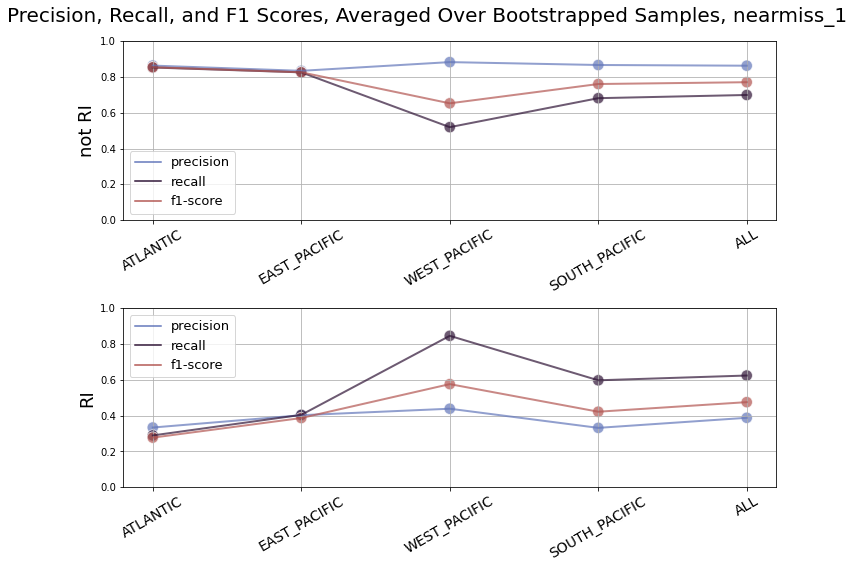

In [29]:
report_plt2 = report_plt_all.loc[['precision','recall','f1-score']].mean(level=(0,1)).reset_index()
fig5,(ax5a,ax5b) = plt.subplots(2,1,figsize=(10,8))
sns.scatterplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',s=130,ax=ax5a,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5a,alpha=0.7)

sns.scatterplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',s=130,ax=ax5b,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5b,alpha=0.7)

ax5a.set_ylim([0,1])
ax5b.set_ylim([0,1])
ax5a.set_ylabel('not RI',fontsize=18)
ax5b.set_ylabel('RI',fontsize=18)
ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5a.set_xlabel(None)
ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5b.set_xlabel(None)
ax5a.grid()
ax5b.grid()
ax5a.legend(fontsize=13)
ax5b.legend(fontsize=13)
fig5.suptitle('Precision, Recall, and F1 Scores, Averaged Over Bootstrapped Samples,'\
              ' {sample_str}'.format(sample_str=sample_save_str),fontsize=20)
fig5.tight_layout()
fig5.savefig(save_dir+'Scores_averaged_RI_non_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')


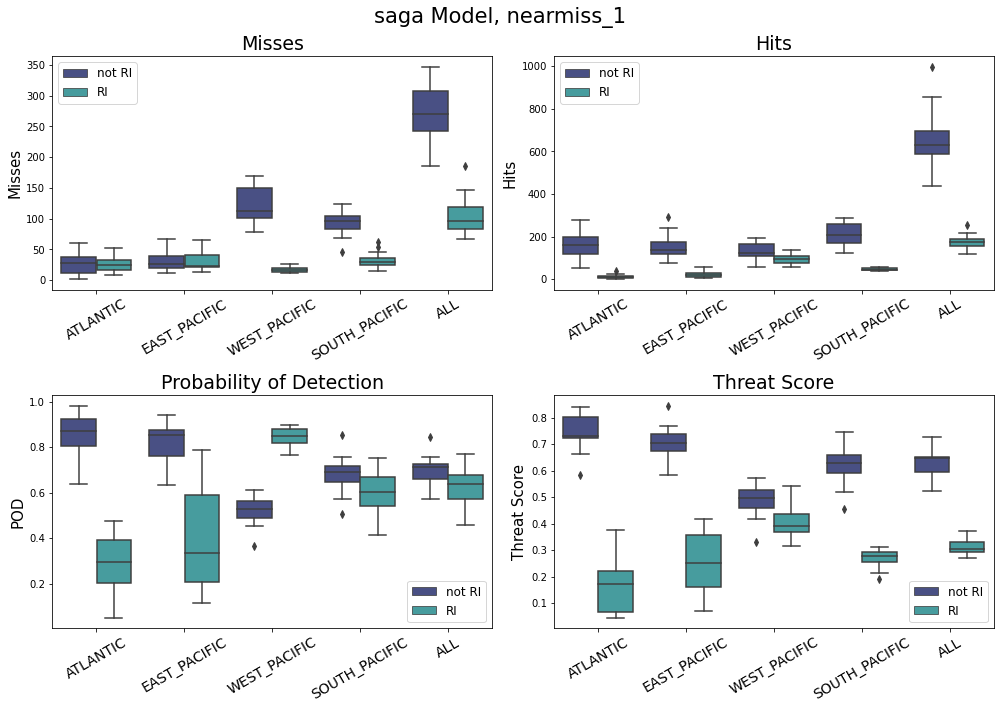

In [30]:
#sns.heatmap(data=cm_ALL,x='Category',y='Misses')
#cm_ALL['BIAS'] = (cm_ALL['Hits']+cm_ALL['False Alarms'])/(cm_ALL['Hits'] + cm_ALL['Misses'])

fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(14,10))
sns.boxplot(data=cm_ALL,x='BASIN',y='Misses',hue='Category Names',palette='mako',ax=ax6a)
ax6a.set_ylabel('Misses',fontsize=15)
ax6a.legend(fontsize=12)
ax6a.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6a.set_title('Misses',fontsize=19)
ax6a.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Hits',hue='Category Names',palette='mako',ax=ax6b)
ax6b.set_ylabel('Hits',fontsize=15)
ax6b.legend(fontsize=12)
ax6b.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6b.set_title('Hits',fontsize=19)
ax6b.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='POD',hue='Category Names',palette='mako',ax=ax6c)
ax6c.set_ylabel('POD',fontsize=15)
ax6c.legend(fontsize=12)
ax6c.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6c.set_title('Probability of Detection',fontsize=19)
ax6c.set_xlabel(None)
#
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Threat',hue='Category Names',palette='mako',ax=ax6d)
ax6d.set_ylabel('Threat Score',fontsize=15)
ax6d.legend(fontsize=12)
ax6d.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6d.set_title('Threat Score',fontsize=19)
ax6d.set_xlabel(None)
#

fig6.suptitle('{solver} Model, {sample_str}'.format(solver=solver,sample_str=sample_save_str),fontsize=21)
fig6.tight_layout()
fig6.savefig(save_dir+'CM_results_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

In [31]:
# fi_plt_plt

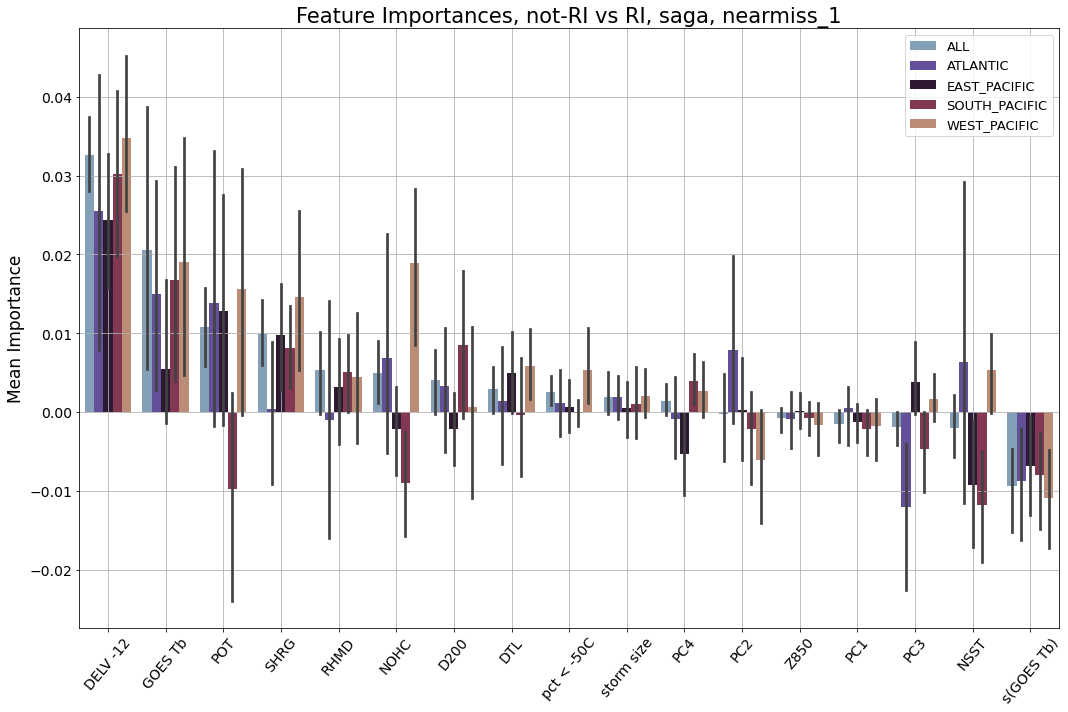

In [32]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.tick_params(axis='y',labelsize=14)
ax7.grid()
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, not-RI vs RI, {solver}, {sample_str}'.format(solver=solver,
                                                                sample_str=sample_save_str),fontsize=21)
fig7.tight_layout()
fig7.savefig(save_dir+'Feat_Imp_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Each basin separately

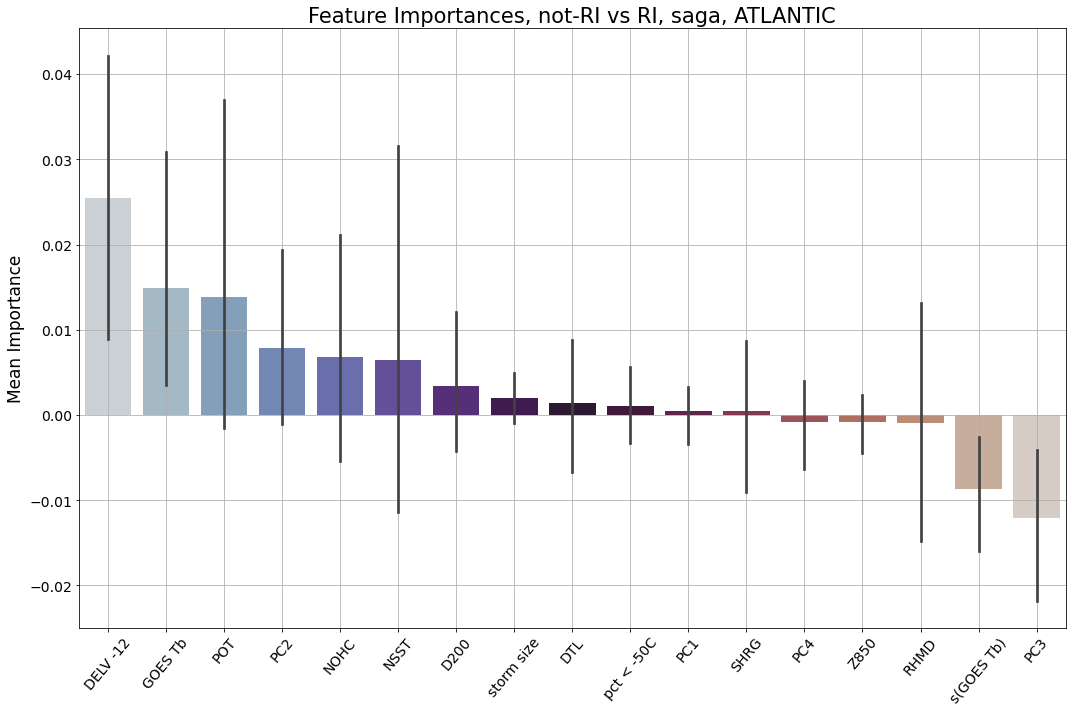

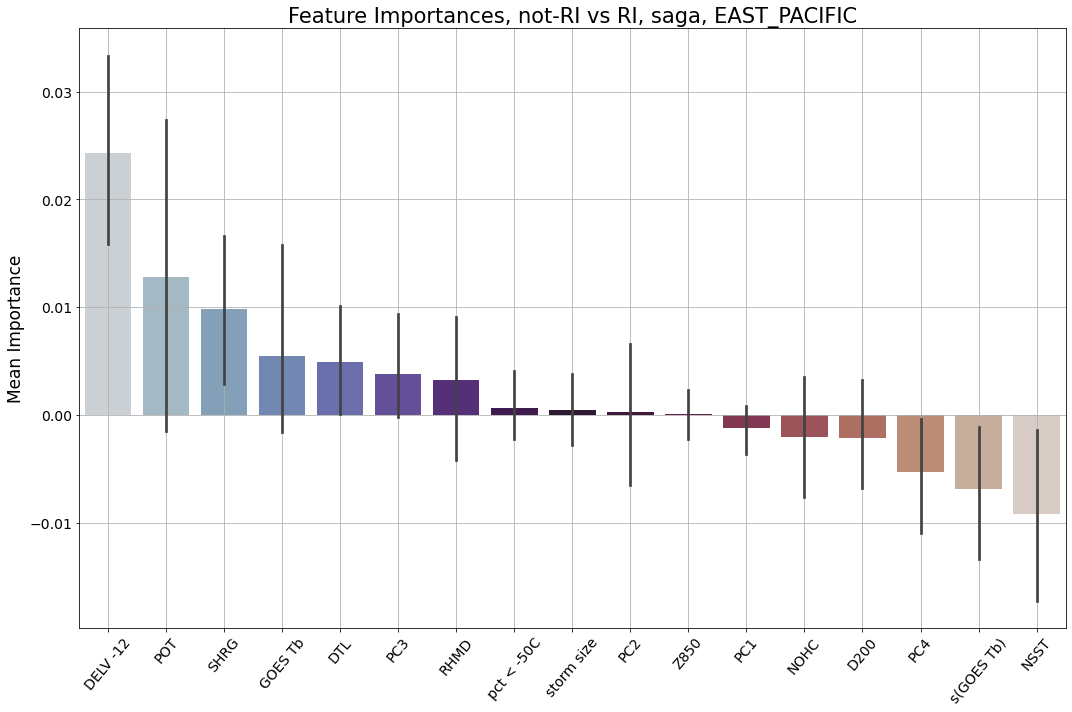

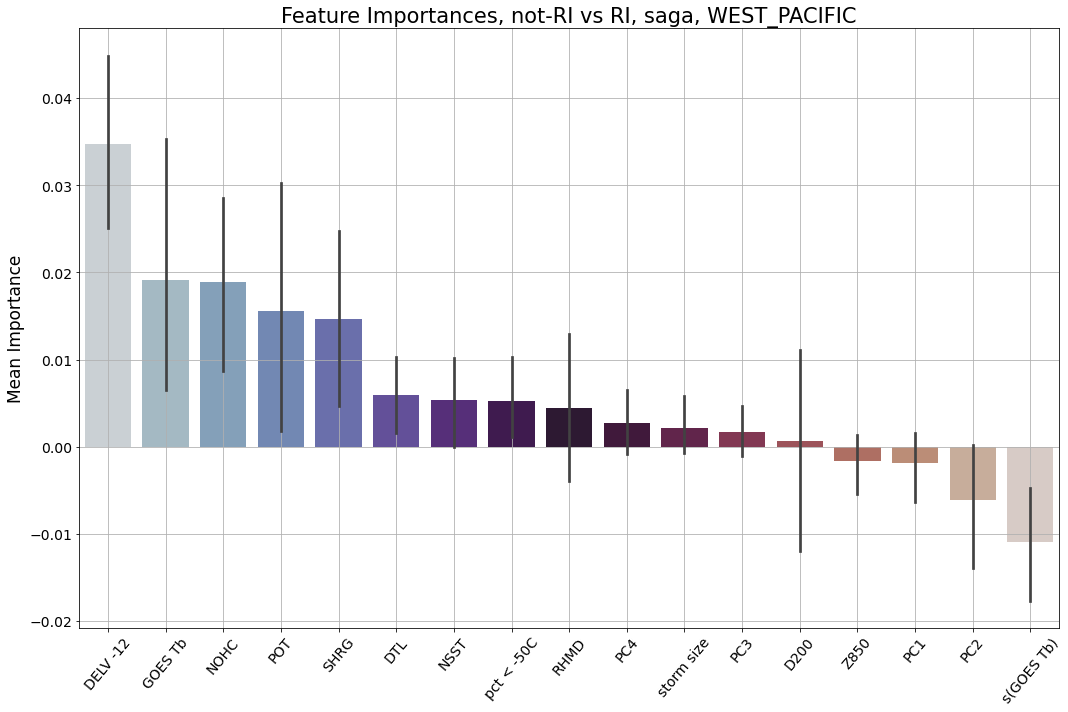

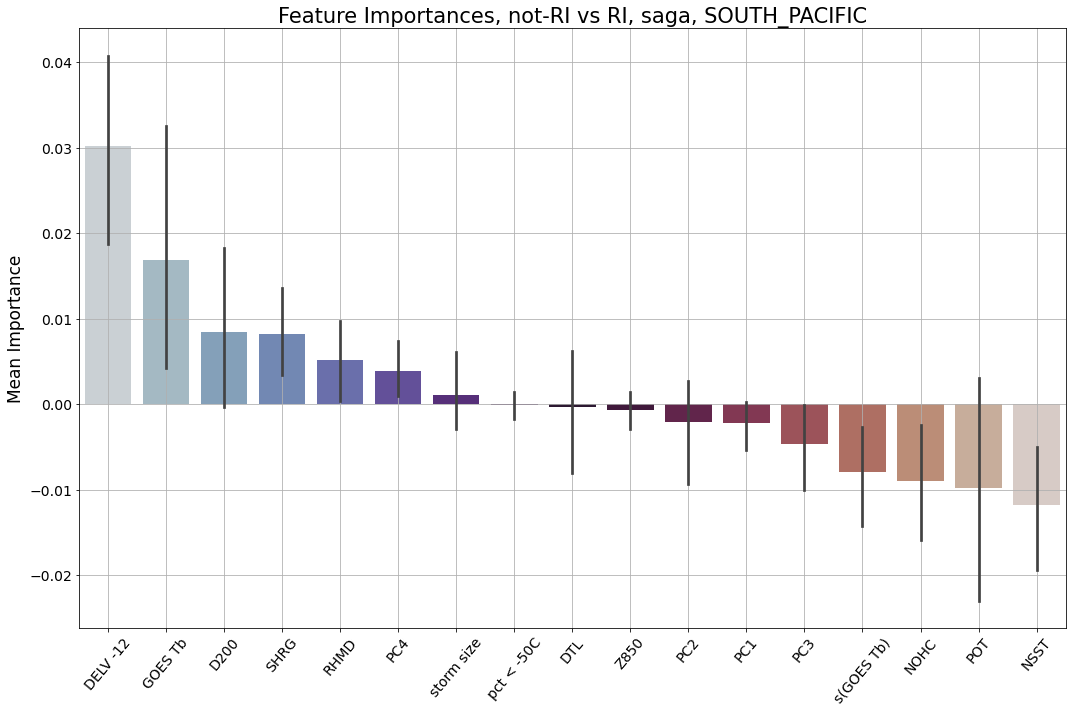

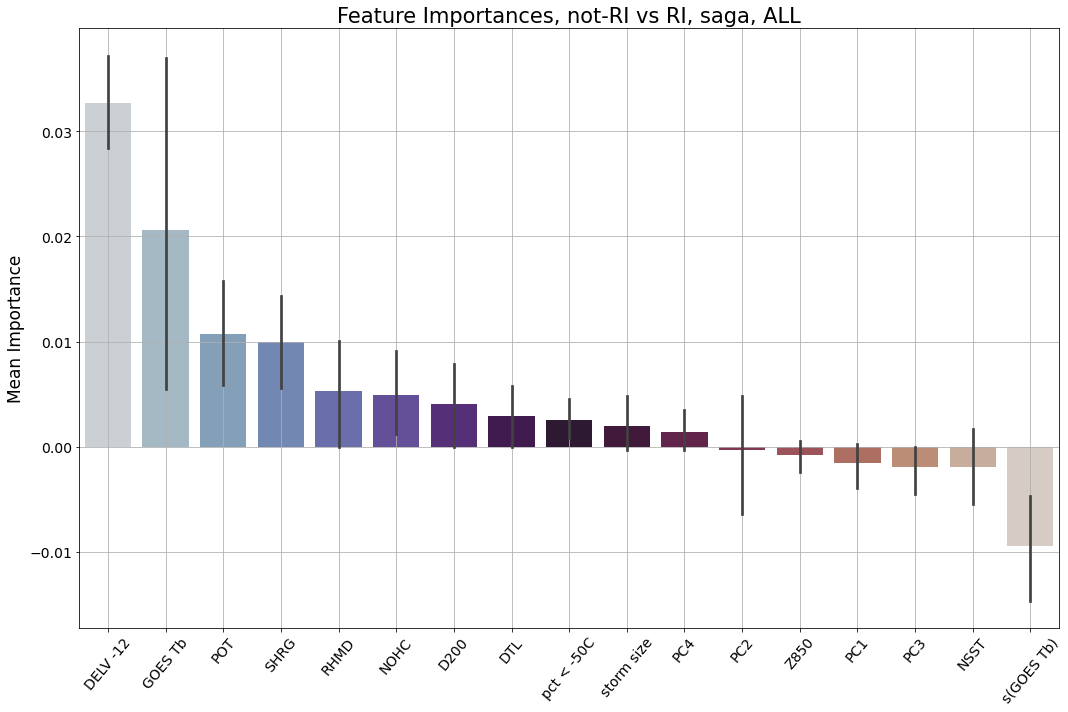

In [33]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, not-RI vs RI, {solver}, {basin}'.format(solver=solver,basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    #fig7.savefig('Model_Results/LOGISTIC/Feat_Imp_RI_not_RI_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
     #           format='png',dpi=250,bbox_inches='tight')


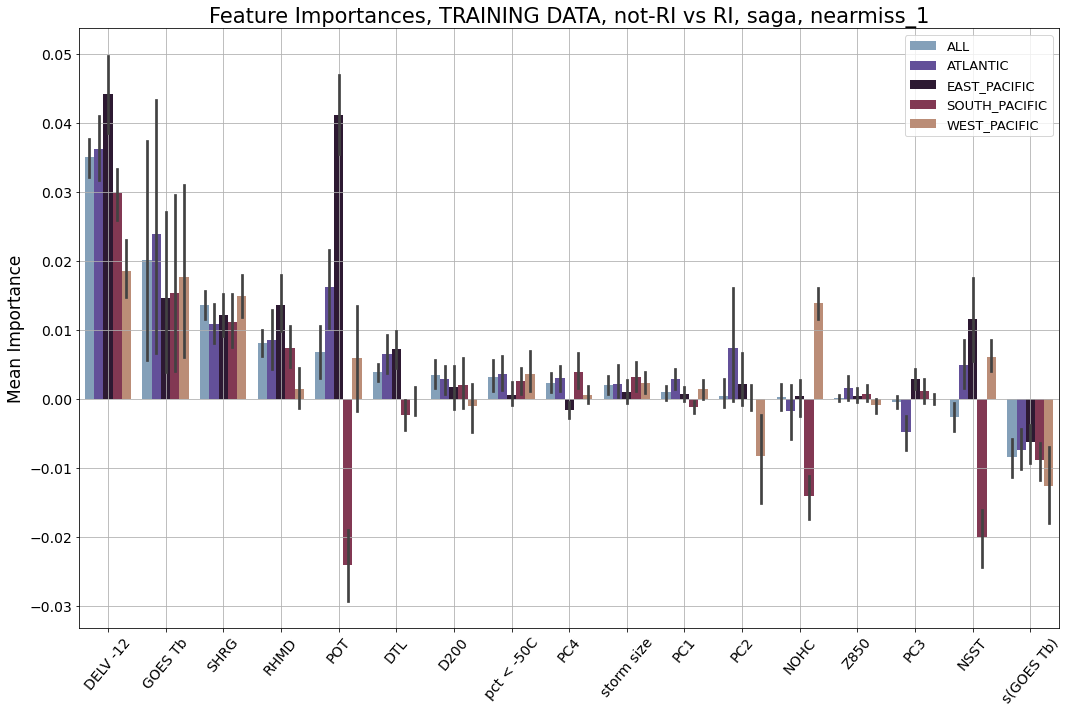

In [36]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_train_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.grid()
ax7.tick_params(axis='y',labelsize=14)
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver},'\
              ' {sample_str}'.format(solver=solver,sample_str=sample_save_str),fontsize=21)
fig7.tight_layout()
fig7.savefig(save_dir+'Feat_Imp_TRAIN_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Each basin separately

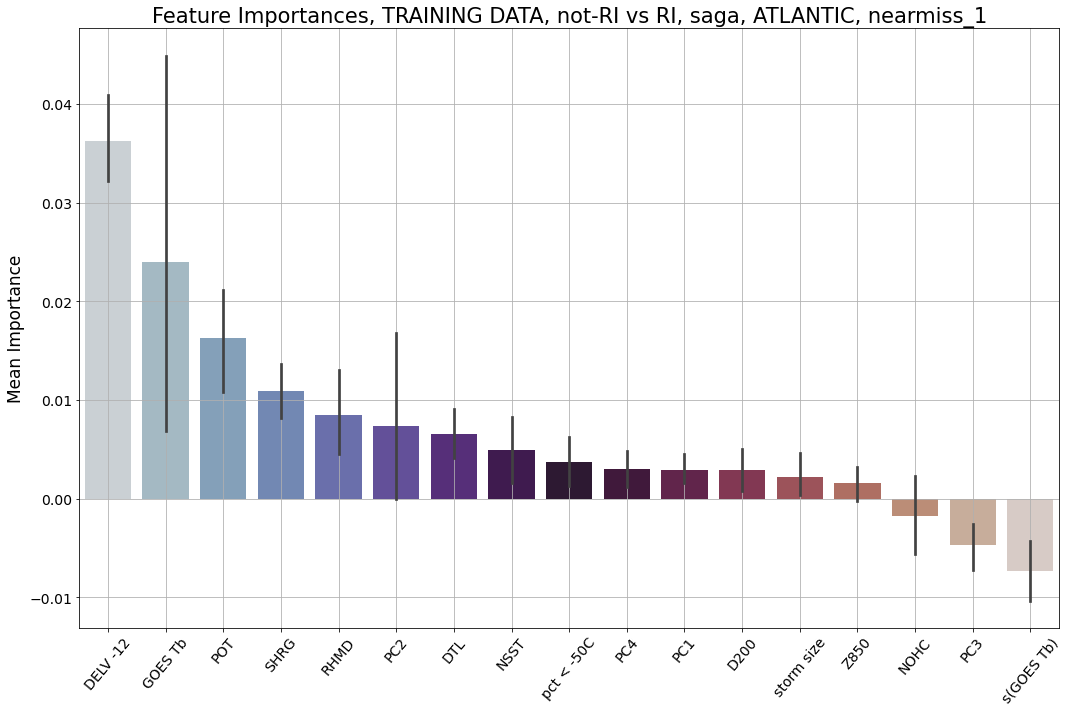

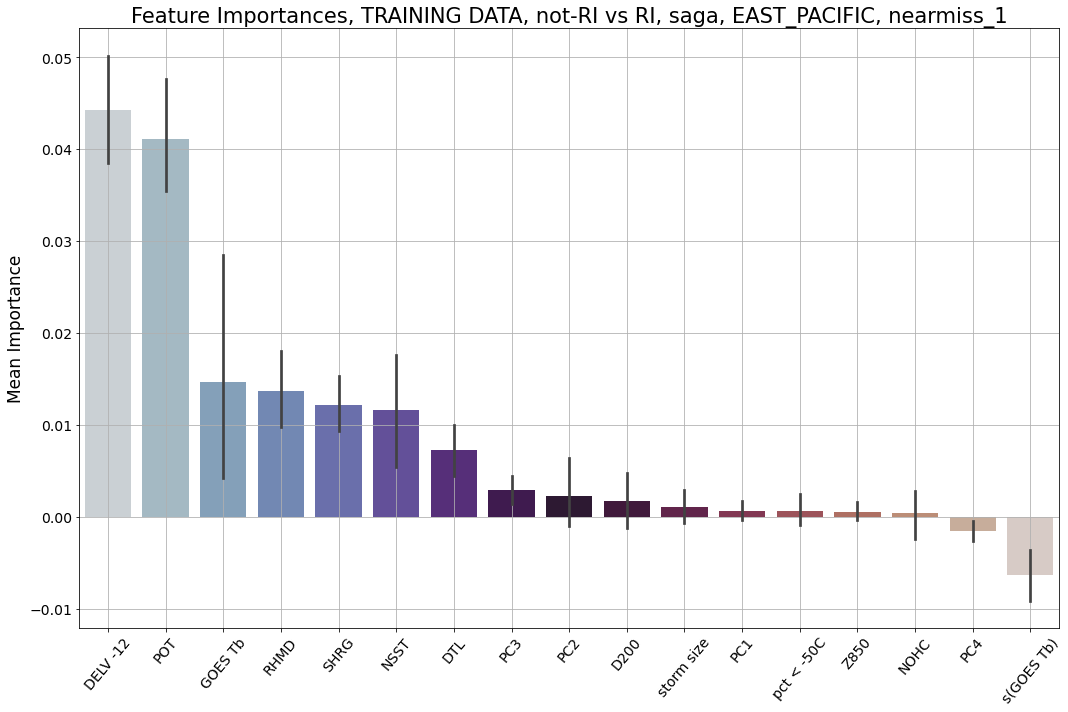

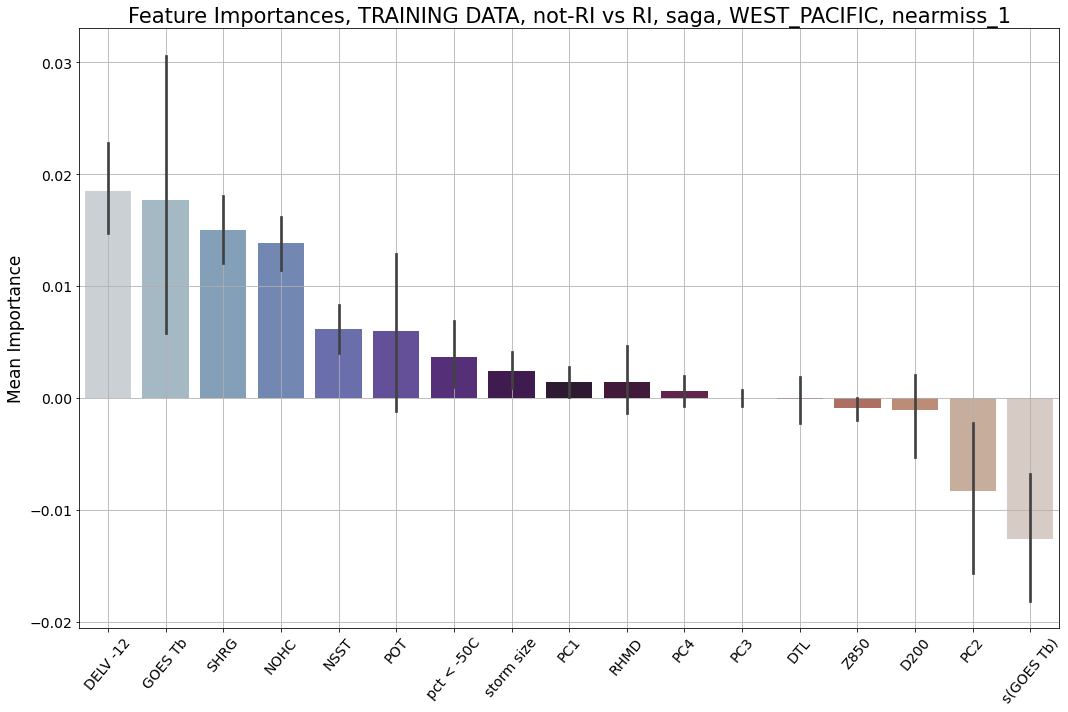

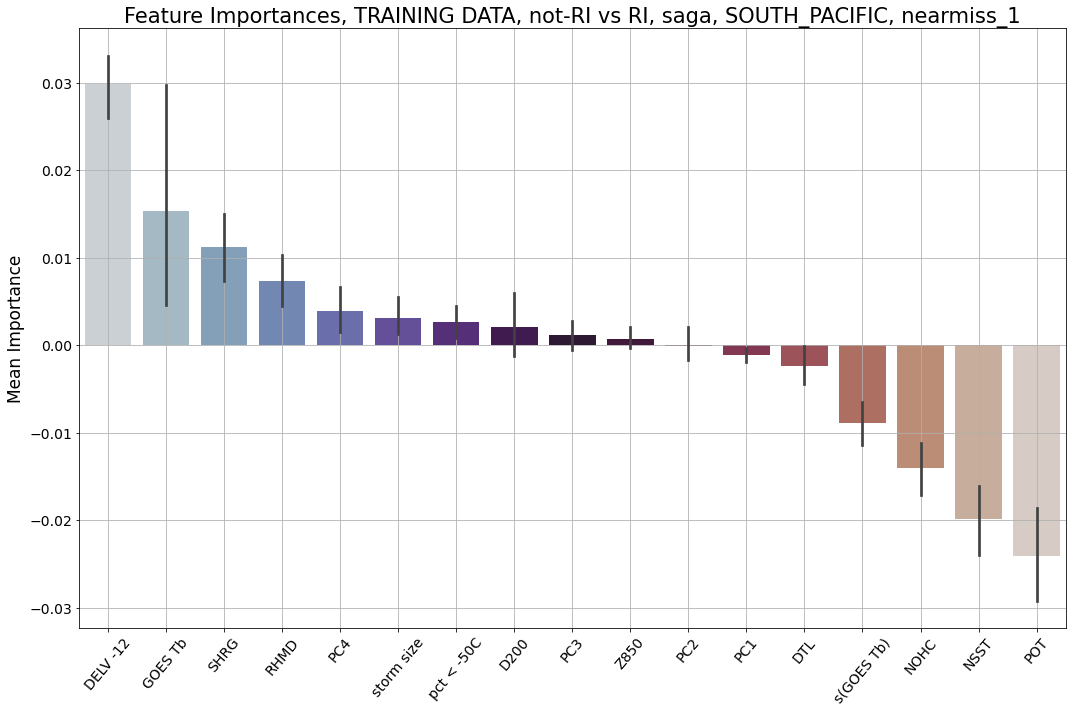

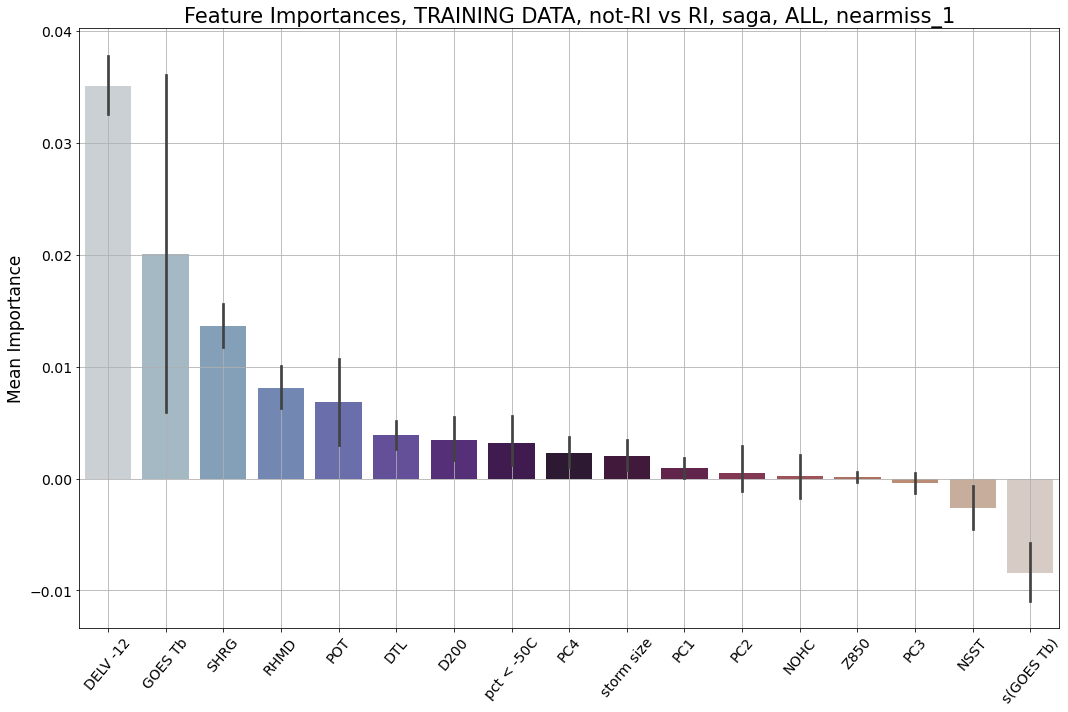

In [37]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_train_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}, '\
                  '{basin}, {sample_str}'.format(solver=solver,basin=basin_sel,sample_str=sample_save_str),fontsize=21)
    fig7.tight_layout()
    fig7.savefig(save_dir+'Feat_Imp_RI_not_RI_TRAINING_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')


In [38]:
fi_pred_ALL.reset_index().sort_values('mean importance',ascending=False).head(20)
cm_ALL.groupby(['Category Names','BASIN','C']).count()

PFOD  Category  Misses  N_actual  \
Category Names BASIN         C                                         
RI             ALL           0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               ATLANTIC      0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               EAST_PACIFIC  0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               SOUTH_PACIFIC 0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               WEST_PACIFIC  0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
not RI         ALL           0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               ATLANTIC      0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               EAST_PACIFIC  0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               SOUTH_PACIFIC 0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   
               WEST_PACIFIC  0.1       9         9       9         9   
                             1.0       3         3       3         3   
                             10.0      1         1       1         1   
                             100.0     2         2       2         2   

                                    N_predicted  POD  False Alarms  Threat  \
Category Names BASIN         C                                               
RI             ALL           0.1              9    9             9       9   
                             1.0              3    3             3       3   
                             10.0             1    1             1       1   
                             100.0            2    2             2       2   
               ATLANTIC      0.1              9    9             9       9   
                             1.0              3    3             3       3   
                             10.0             1    1             1       1   
                             100.0            2    2             2       2   
               EAST_PACIFIC  0.1              9    9             9       9   
                             1.0              3    3             3       3   
                             10.0             1    1             1       1 

##### What do we need for a performance diagram?
* Success ratio
* Probability of detection
* Bias
* Threat score / Critical Success Index 
* Uncertainy for POD and success ratio

1. X/Y axis is in POD / Success ratio space
2. Then we have dashed lines showing bias scores, and solid contours labeling CSI 

/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/SHIPS/SHIPS_clean/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


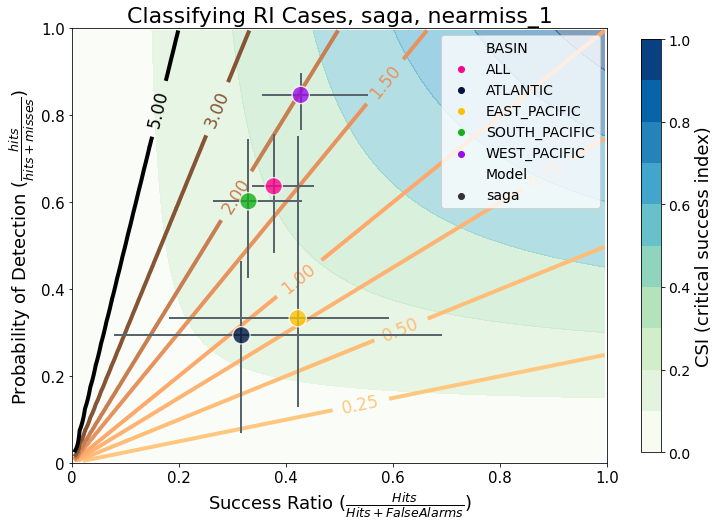

In [39]:
fig12,ax12 = plt.subplots(1,1,figsize=(12,8))
make_performance_diagram_background(ax12)

ax12.set_title('Classifying RI Cases, {solver}, {sample_str}'.format(solver=solver,
                                                                    sample_str=sample_save_str),fontsize=22)
add_model_results(ax12,cm_ALL)
ax12.set_xlim([0,1])
ax12.set_ylim([0,1])
fig12.savefig(save_dir+'Performance_Diagram'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Performance Diagram curves: PoD vs Success Ratio

1. PoD vs Success Ratio curves.  Each fold shown separately, and then averaged across all folds.  Each basin will be separate.
2. AUPD (area under performance diagram) scores. Calculated for each fold and shown as a swarm or box plot, all basins on one plot
3. Max CSI. Calculated for each fold / basin and shown as swarm or box plot, all basins on one plot. 
4. CSI vs Bias.  Calculated for each fold / basin and shown as scatterplot, all basins on one plot. Also show mean across all folds. 


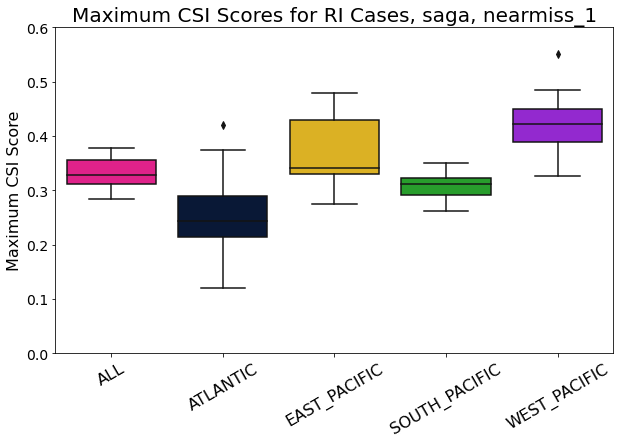

In [40]:
pd_curves = calculate_PD_curves(p_vs_r_ALL)
fig15,ax15 = plt.subplots(1,1,figsize=(10,6))
max_CSI_ind = p_vs_r_ALL.groupby(['BASIN','Fold'])[['CSI','Bias']].agg({'CSI':'max'}).reset_index()
plot_basic_score_basin(ax15,max_CSI_ind,'CSI',False)
ax15.set_title('Maximum CSI Scores for RI Cases, {solver}, {sample_str}'.format(solver=solver,
                                                                sample_str=sample_save_str),fontsize=20)
ax15.set_ylabel('Maximum CSI Score',fontsize=16)
ax15.set_ylim([0,0.6])
fig15.savefig(save_dir+'Max_CSI_RI_vs_basin'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

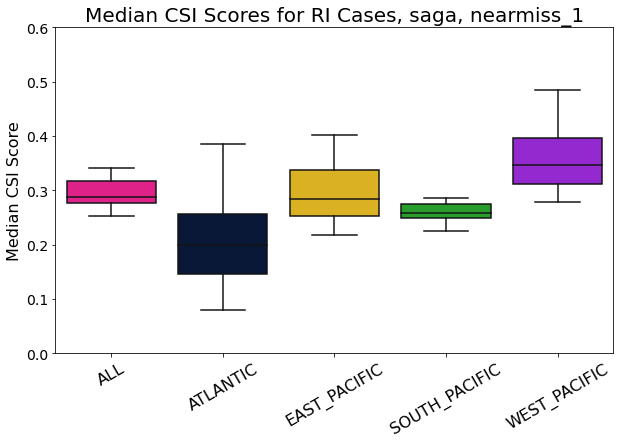

In [41]:
fig15,ax15 = plt.subplots(1,1,figsize=(10,6))
med_CSI_ind = p_vs_r_ALL.groupby(['BASIN','Fold'])[['CSI','Bias']].agg({'CSI':'median'}).reset_index()
plot_basic_score_basin(ax15,med_CSI_ind,'CSI',False)
ax15.set_title('Median CSI Scores for RI Cases, {solver}, {sample_str}'.format(solver=solver,
                                                                sample_str=sample_save_str),fontsize=20)
ax15.set_ylabel('Median CSI Score',fontsize=16)
ax15.set_ylim([0,0.6])
fig15.savefig(save_dir+'Median_CSI_RI_vs_basin'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

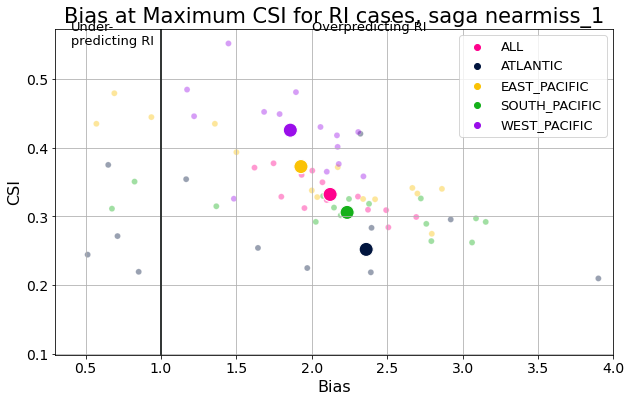

In [42]:
#sns.swarmplot(data=foo2.reset_index(),x='BASIN',y='CSI')
fig30,ax30 = plt.subplots(1,1,figsize=(10,6))
plot_CSI_vs_bias(p_vs_r_ALL,ax30)
ax30.set_title('Bias at Maximum CSI for RI cases, {solver} '\
               '{sample_str}'.format(solver=solver,sample_str=sample_save_str),fontsize=21)
fig30.savefig(save_dir+'CSI_vs_bias_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

<AxesSubplot:xlabel='Bias', ylabel='CSI'>

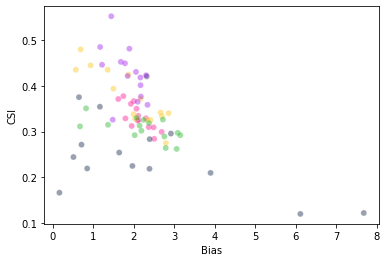

In [43]:
b_c_max = p_vs_r_ALL.sort_values(['CSI'], ascending=[False]).groupby(['BASIN','Model','Fold']).first()
sns.scatterplot(data=b_c_max.reset_index(),x='Bias',y='CSI',hue='BASIN',style='Model',alpha=0.4,legend=False)

##### Area under PD Curve

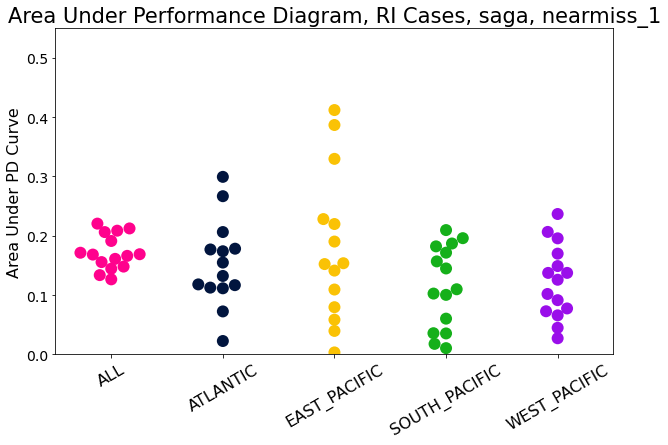

In [44]:
aupd_scores = calc_AUPD(p_vs_r_ALL)
aupd_plt = aupd_scores.reset_index().rename(columns={0:'AUPD'})
fig14,ax14 = plt.subplots(1,1,figsize=(10,6))
plot_basic_score_basin(ax14,aupd_plt,'AUPD',True)
ax14.set_ylabel('Area Under PD Curve',fontsize=16)
ax14.set_title('Area Under Performance Diagram, RI Cases, {solver}, {sample_str}'.format(solver=solver,
                                                sample_str=sample_save_str),fontsize=21)
ax14.set_ylim([0,0.55])
fig14.savefig(save_dir+'AUPD_calculation_RI_cases'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

In [45]:
import warnings
warnings.filterwarnings("ignore")

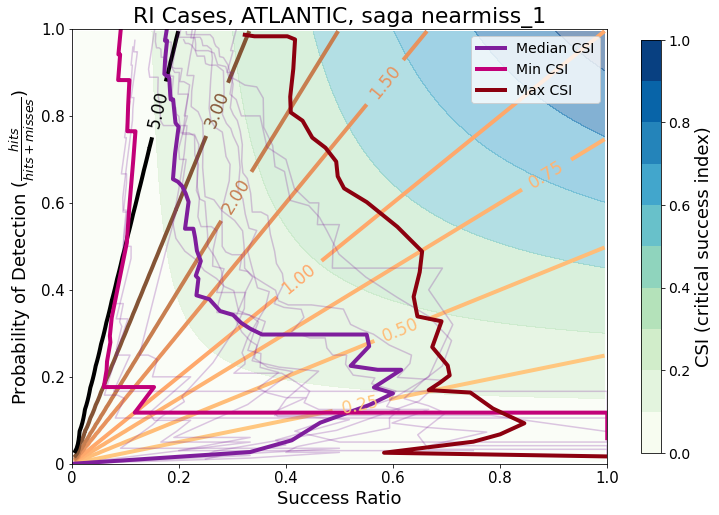

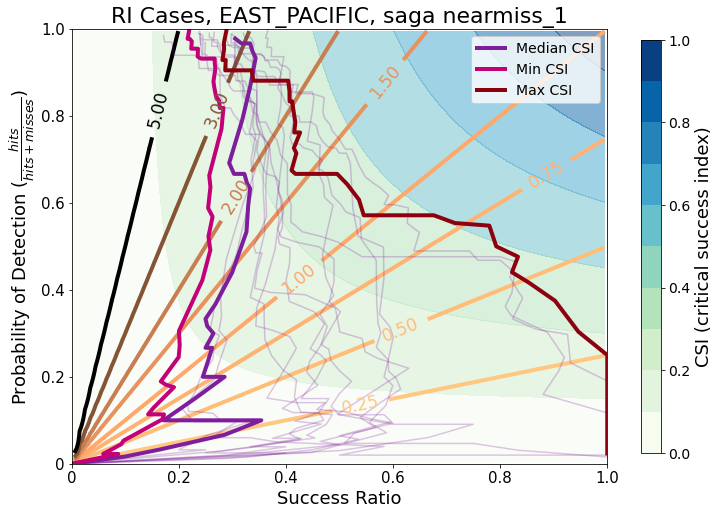

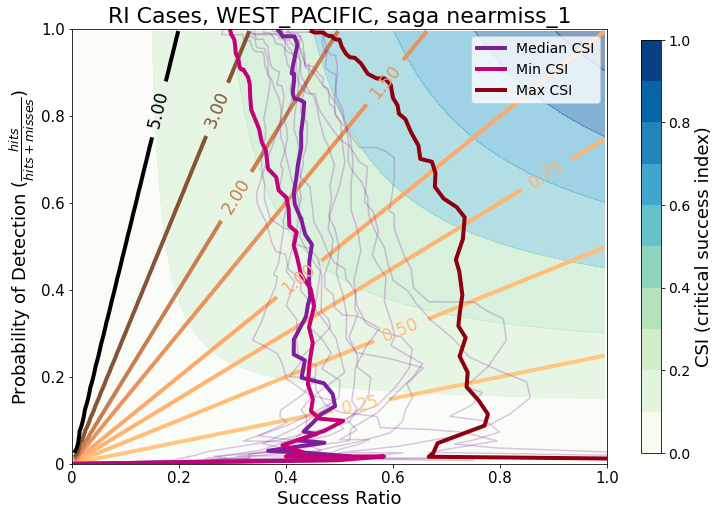

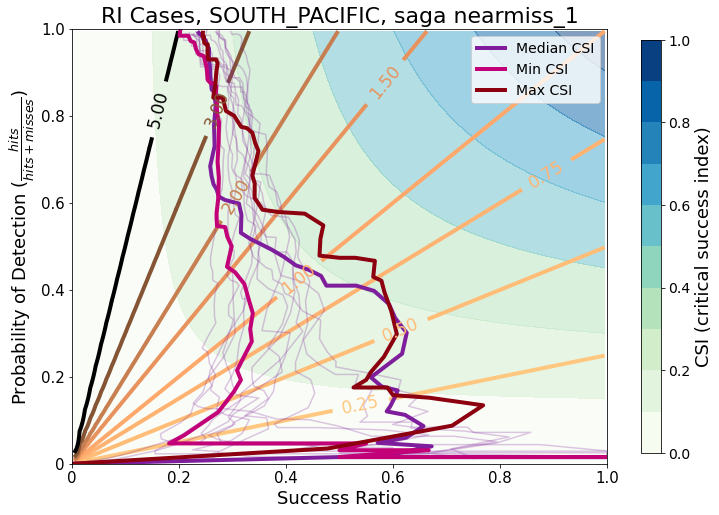

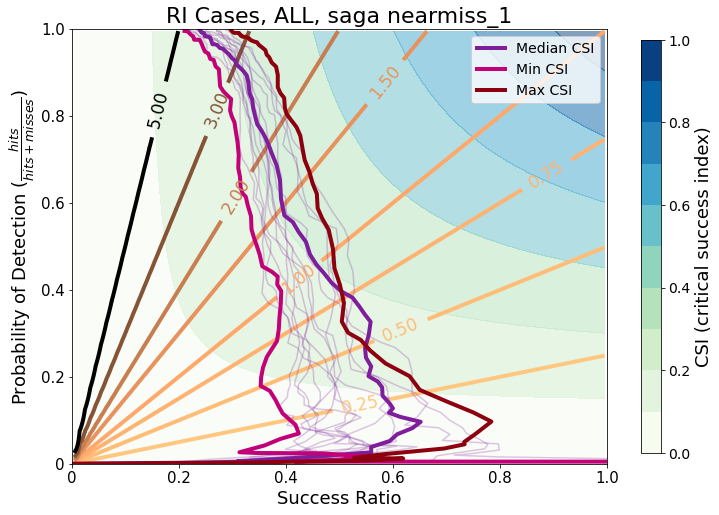

In [46]:
for basin_sel in BASIN_all:
    fig23,ax23 = plt.subplots(1,1,figsize=(12,8))
    make_performance_diagram_background(ax23)
    plot_PD_curves(p_vs_r_ALL,ax23,basin_sel)
    ax23.set_title('RI Cases, {basin_sel}, {solver} {sample_str}'.format(basin_sel=basin_sel,
                                        solver=solver,sample_str=sample_save_str),fontsize=22)
    f23_save = save_dir+'Performance_Diagram_CURVES_{basin_sel}'.format(basin_sel=basin_sel)
    fig23.savefig(f23_save+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')